In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import PolynomialFeatures
import shap
import matplotlib.pyplot as plt
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

In [14]:
df = pd.read_parquet("allocine_spider_clean.parquet")
df.head(5)


,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,us_first_week_boxoffice,french_first_week_boxoffice,french_visa,title,vo_title,url
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,NaN,110011.0,157303,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....
1,"[Monica Bellucci, Vincent Cassel, Albert Dupon...",3.5,2020-08-26,[Gaspar Noé],Carlotta Films,"[Drame, Thriller]","[Anglais, Français, Italien, Espagnol]",90.0,[France],NaN,NaN,2905.0,153336,Irréversible - Inversion Intégrale,None,/article/fichearticle_gen_carticle=18692477.html
2,[Thom Hoffman],2.8,2024-08-07,"[Richard Claus, Karsten Kiilerich]",Le Pacte,"[Aventure, Animation, Comédie, Famille]",[Néerlandais],84.0,"[Danemark, France, Allemagne, Pays-Bas]",3.0,NaN,39119.0,160622,Petit Panda en Afrique,Panda Bear in Africa,/article/fichearticle_gen_carticle=1000096064....
3,"[Lou de Laâge, Raphaël Personnaz, Isabelle Car...",3.3,2022-12-21,[Olivier Treiner],SND,[Drame],[Français],120.0,[France],3.8,NaN,64039.0,152607,Le Tourbillon de la vie,None,/article/fichearticle_gen_carticle=1000006465....
4,"[Michael B. Jordan, Jamie Foxx, Brie Larson, R...",3.0,2020-01-29,[Destin Daniel Cretton],Warner Bros. France,"[Biopic, Drame]",[Anglais],137.0,[U.S.A.],4.1,9713228.0,113153.0,152118,La Voie de la justice,Just Mercy,/video/player_gen_cmedia=19586793&cfilm=239735...


In [3]:
features_of_interest = [
    'actors',
    'date',
    'director',
    'editor',
    'genre',
    'langage',
    'length',
    'nationality'
]

info_film = ['french_visa', 'title', 'vo_title', 'url']

numerical_features = ['length']
date_feature = ['date']
categorical_features = ['director', 'editor']
list_categorical_features = ['actors', 'genre', 'langage', 'nationality']


list_categorical_features = ['actors', 'genre', 'langage', 'nationality']
for col in list_categorical_features:
    df[col] = df[col].mask(df[col].isna(), ['no value'])

target = 'french_first_week_boxoffice'

X, y = (
    df[features_of_interest],
    df[target]
)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

In [4]:
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlbs = {}  # Stocke un MultiLabelBinarizer pour chaque colonne
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.mlbs[col] = MultiLabelBinarizer()
            self.mlbs[col].fit(X[col])
        return self
    
    def transform(self, X):
        transformed_list = []
        for col in X.columns:
            transformed = self.mlbs[col].transform(X[col])
            new_columns = [f"{col}_{label}" for label in self.mlbs[col].classes_]
            transformed_list.append(pd.DataFrame(transformed, columns=new_columns, index=X.index))
        
        return pd.concat(transformed_list, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # Collecter tous les noms de colonnes de sortie
        feature_names = []
        for col in self.mlbs.keys():
            feature_names.extend([f"{col}_{label}" for label in self.mlbs[col].classes_])
        return np.array(feature_names)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Bourin... à changer mais j'ai même pas vérifier s'il manquait des données...
    ('scaler', StandardScaler())
])

class CustomDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = ['year', 'month', 'day', 'dayofweek']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        result = pd.DataFrame({
            'year': X['date'].dt.year,
            'month': X['date'].dt.month,
            'day': X['date'].dt.day,
            'dayofweek': X['date'].dt.dayofweek
        })
        return result
        
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out)

date_transformer = Pipeline(steps=[
    ('date_features', CustomDateTransformer())
])

# Toujours bourin :p
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_categorical_transformer = Pipeline(steps=[
    ('multi_label', MultiLabelBinarizerTransformer())
])

# Création du préprocesseur (sans les colonnes déjà transformées)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

In [5]:
#Lasso

list_categorical_features = ['genre', 'langage', 'nationality', 'actors']
for col in list_categorical_features:
    df[col] = df[col].mask(df[col].isna(), ['no value'])
    
df['french_prod']= df['nationality'].apply(lambda x: 1 if "France" in x else 0)
df['usa_prod']= df['nationality'].apply(lambda x: 1 if "U.S.A." in x else 0)


list_categorical_features = ['genre', 'langage']
features_of_interest = [
    'french_prod',
    'date',
    'director',
    'editor',
    'genre',
    'langage',
    'length',
    'usa_prod',
]

info_film = ['french_visa', 'title', 'vo_title', 'url']

numerical_features = ['length']
date_feature = ['date']
categorical_features = ['director', 'editor']
list_categorical_features = ['genre', 'langage']


target = 'french_first_week_boxoffice'

X, y = (
    df[features_of_interest],
    df[target]
)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

lasso_model = Pipeline([
    ('preprocessor', preprocessor),  
    ('lassomodel', Lasso(alpha=10, random_state=42))
])

lasso_model.fit(X_train,y_train)
y_pred = lasso_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape} %")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 174586.29661733532
MAPE: 116.66422190675844 %
RMSE: 540647.6839939922
R²: 0.6920804946973367


/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [12]:
def get_feature_names_from_column_transformer(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            if transformer == 'passthrough':
                # Cas où 'passthrough' est utilisé
                if isinstance(columns, slice):
                    passthrough_columns = column_transformer._feature_names_in_[columns]
                else:
                    passthrough_columns = columns
                feature_names.extend(passthrough_columns)
            continue

        # Si c'est une pipeline imbriquée (ex: ('cat', Pipeline([...]), cols))
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps[list(transformer.named_steps)[-1]]

        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(columns)
            except:
                names = transformer.get_feature_names_out()
        else:
            names = columns

        feature_names.extend(names)

    return feature_names


/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, pre

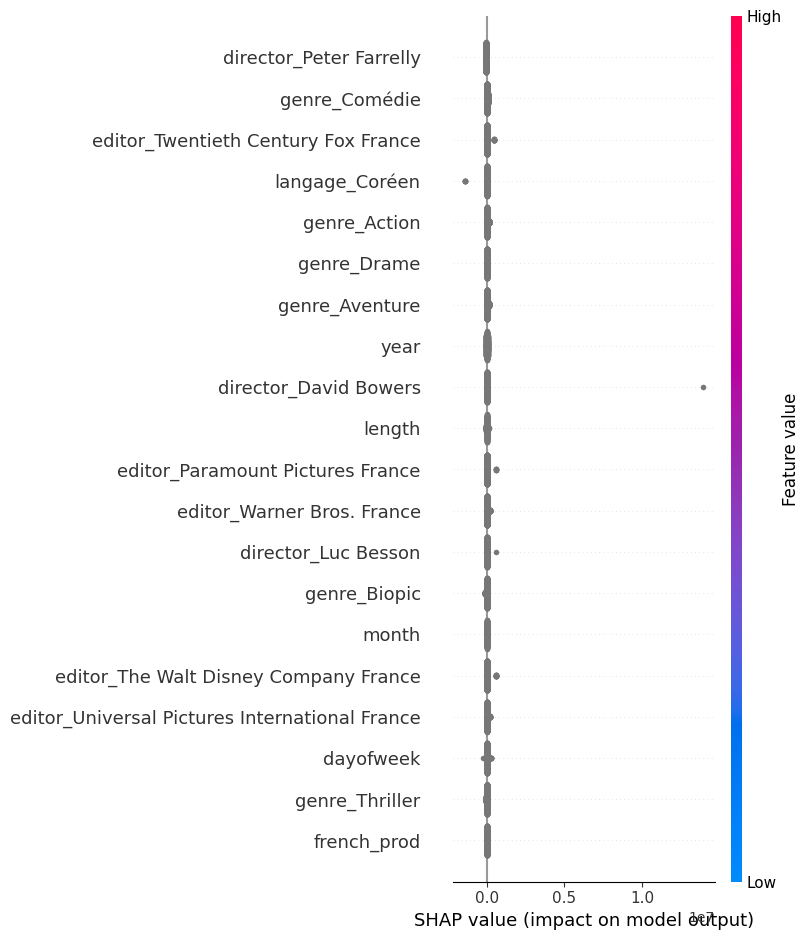

In [ ]:
# Étape 1 : fit uniquement le préprocesseur
preprocessor.fit(X_train)

# Étape 2 : transformer les données
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Étape 3 : entraîner le modèle Lasso uniquement
lasso = Lasso(alpha=10, random_state=42)
lasso.fit(X_train_transformed, y_train)

# Étape 4 : récupérer les noms des features après preprocessing
feature_names = get_feature_names_from_column_transformer(preprocessor)

# Étape 5 : création du SHAP explainer
explainer = shap.Explainer(lasso, X_train_transformed, feature_names=feature_names)

# Étape 6 : calcul des SHAP values sur le test set
shap_values = explainer(X_test_transformed)

# Étape 7 : plot SHAP summary
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names)


In [15]:
df.head(5)

,actors,critics_score,date,director,editor,genre,langage,length,nationality,viewers_score,french_first_week_boxoffice,french_visa,title,vo_title,url
0,"[George Clooney, Julia Roberts, Jack O'Connell]",3.5,2016-05-12,Jodie Foster,Sony Pictures Releasing France,[Thriller],[Anglais],99.0,[U.S.A.],3.6,305385.0,144018,Money Monster,None,/video/player_gen_cmedia=19561526&cfilm=214139...
1,"[Kad Merad, Géraldine Pailhas, Lola Creton]",2.7,2015-01-21,Christophe Lamotte,Rezo Films,"[Drame, Thriller]",[Français],100.0,[France],2.3,29265.0,117439,Disparue en hiver,None,/article/fichearticle_gen_carticle=18639324.html
2,"[Nicolas Cage, Kev Adams, Ryan Reynolds]",3.8,2013-04-10,Chris Sanders,Twentieth Century Fox France,"[Aventure, Animation, Comédie, Famille]",[Anglais],98.0,[U.S.A.],3.9,501465.0,135882,Les Croods,The Croods,/video/player_gen_cmedia=19410286&cfilm=146916...
3,"[Dylan O'Brien, Michael Keaton, Taylor Kitsch]",2.3,2017-09-20,Michael Cuesta,Metropolitan FilmExport,"[Action, Thriller]",[Anglais],112.0,[U.S.A.],3.2,104402.0,147308,American Assassin,None,/video/player_gen_cmedia=19569927&cfilm=194970...
4,"[Virginie Efira, Anaïs Demoustier, Laurent Sto...",3.5,2015-04-22,Emmanuel Mouret,Pyramide Distribution,"[Comédie, Romance]",[Français],100.0,[France],2.7,64046.0,138835,Caprice,None,/diaporamas/cinema/diaporama-18643599/


In [1]:
file_name = "actors_jpbox"
version="2.0"

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get(file_name, version=version)

df_actors = pd.read_parquet(data_asset.path)
df_actors['name'] = df_actors["name"].apply(lambda x : x.replace(" ", "").replace("-", "").replace("_", "").strip().lower())
df_actors.set_index('name', inplace=True)
df_actors.head()

NameError: name 'MLClient' is not defined

In [4]:
list_categorical_features = ['genre', 'langage', 'nationality', 'actors']
for col in list_categorical_features:
    df[col] = df[col].mask(df[col].isna(), ['no value'])

In [5]:
df

,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,french_first_week_boxoffice,french_visa,title,vo_title,url
0,no value,4.4,2023-09-27,[Cédric Kahn],Ad Vitam,no value,no value,116.0,no value,3.9,110011.0,157303,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....
1,no value,3.5,2020-08-26,[Gaspar Noé],Carlotta Films,no value,no value,90.0,no value,NaN,2905.0,153336,Irréversible - Inversion Intégrale,None,/article/fichearticle_gen_carticle=18692477.html
2,no value,2.8,2024-08-07,"[Richard Claus, Karsten Kiilerich]",Le Pacte,no value,no value,84.0,no value,3.0,39119.0,160622,Petit Panda en Afrique,Panda Bear in Africa,/article/fichearticle_gen_carticle=1000096064....
3,no value,3.3,2022-12-21,[Olivier Treiner],SND,no value,no value,120.0,no value,3.8,64039.0,152607,Le Tourbillon de la vie,None,/article/fichearticle_gen_carticle=1000006465....
4,no value,3.0,2020-01-29,[Destin Daniel Cretton],Warner Bros. France,no value,no value,137.0,no value,4.1,113153.0,152118,La Voie de la justice,Just Mercy,/video/player_gen_cmedia=19586793&cfilm=239735...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9153,no value,3.2,2022-08-03,[David Leitch],Sony Pictures Releasing France,no value,no value,127.0,no value,3.9,491067.0,157053,Bullet Train,None,/video/player_gen_cmedia=19596933&cfilm=284846...
9154,no value,3.8,2024-10-30,[Clint Eastwood],Warner Bros. France,no value,no value,114.0,no value,3.9,453813.0,-,Juré n°2,Juror #2,/video/player_gen_cmedia=20609934&cfilm=314868...
9155,no value,3.5,2022-05-11,[François Uzan],UGC Distribution,no value,no value,96.0,no value,2.8,37740.0,153600,On sourit pour la photo,None,/article/fichearticle_gen_carticle=18709697.html
9156,no value,3.6,2024-05-01,"[Juan Sebastián Vásquez, Alejandro Rojas]",Condor Distribution,no value,no value,77.0,no value,3.8,44476.0,161784,Border Line,Upon Entry (La llegada),/video/player_gen_cmedia=20601439&cfilm=309465...


In [6]:
file_name = "cncAffluence"
version="2.0.0"

ml_client = MLClient(
    credential=DefaultAzureCredential(),
    subscription_id="72eb7803-e874-44cb-b6d9-33f2fa3eb88c",
    resource_group_name="vpoutotrg",
    workspace_name="mlstudio-groupe4"
)

data_asset = ml_client.data.get(file_name, version=version)

df_afluence = pd.read_parquet(data_asset.path)
df_afluence.head()

Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


,box_office,is_prediction
month,,
2009-01-01,15.148333,0
2009-02-01,19.348000,0
2009-03-01,20.087500,0
2009-04-01,16.975000,0
2009-05-01,14.528333,0


In [7]:


file_name = "cncAffluence"
version="2.0.1"
data_asset = ml_client.data.get(file_name, version=version)

df_afluence_filled = pd.read_parquet(data_asset.path)
df_afluence_filled.head()



,box_office,is_prediction
month,,
1989-01-01,9.822903,1.0
1989-02-01,11.884946,1.0
1989-03-01,11.417790,1.0
1989-04-01,10.506531,1.0
1989-05-01,9.071718,1.0


In [15]:
def remove_target_outliers(df, target_column, factor=1.5, max_values=True):
    """
    Supprime les outliers de la variable cible.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    target_column : str
        Nom de la colonne cible
    factor : float, default=1.5
        Facteur multiplicatif de l'IQR pour définir le seuil des outliers
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers sur la cible
    """
    # Calcul des statistiques
    Q1 = df[target_column].quantile(0.25)
    Q3 = df[target_column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Définition des bornes
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Filtrage
    if max_values:
        df_clean = df[(df[target_column] >= lower_bound) & (df[target_column] <= upper_bound)]
    else:
        df_clean = df[(df[target_column] >= lower_bound)]
    
    # Statistiques sur les outliers supprimés
    n_removed = len(df) - len(df_clean)
    print(f"Nombre d'outliers supprimés : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    print(f"Valeur minimale conservée : {df_clean[target_column].min()}")
    if max_values:
        print(f"Valeur maximale conservée : {df_clean[target_column].max()}")
    
    return df_clean

def remove_outliers_zscore(df, columns, threshold=3.0):
    """
    Supprime les outliers basés sur le z-score (nombre d'écarts-types par rapport à la moyenne).
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Le dataframe à nettoyer
    columns : list
        Liste des colonnes à traiter
    threshold : float, default=3.0
        Seuil de z-score au-delà duquel une valeur est considérée comme outlier
        
    Returns:
    --------
    pandas.DataFrame
        Dataframe sans outliers
    """
    df_clean = df.copy()
    
    for col in columns:
        # Calcul des z-scores
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        z_scores = abs((df_clean[col] - mean) / std)
        
        # Suppression des outliers
        df_clean = df_clean[z_scores < threshold]
    
    # Affichage du nombre de lignes supprimées
    n_removed = len(df) - len(df_clean)
    print(f"Nombre de lignes supprimées : {n_removed} ({n_removed/len(df)*100:.2f}%)")
    
    return df_clean

def put_national_affluence(x, filled = False):
    date = pd.to_datetime(f"{x.year}-{x.month:02d}-01")
    if filled:
        return df_afluence_filled.loc[date, 'box_office'] if date in df_afluence_filled.index else None
    else:
        return df_afluence.loc[date, 'box_office'] if date in df_afluence.index else None
def max_score_actors(x, method="boxoffice_average"):
    max_score = 0
    for actor in x:
        if actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower() in df_actors.index :
            max_score = max(max_score, df_actors.loc[actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower(), method])
    return max_score

def mean_score_actors(x, method="boxoffice_average"):
    scores = []
    for actor in x:
        if actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower() in df_actors.index :
            scores.append(df_actors.loc[actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower(), method])
    if len(scores) == 0:
        mean_scores = 0
    else:
        mean_scores = np.mean(scores)
    return mean_scores

def sum_score_actors(x, method="boxoffice_average"):
    sum_score = 0
    for actor in x:
        if actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower() in df_actors.index :
            sum_score += df_actors.loc[actor.replace(" ", "").replace("-", "").replace("_", "").strip().lower(), method]
    return sum_score
    


features_of_interest = [
    'french_prod',
    'date',
    'directors',
    'editor',
    'genre',
    'length',
    'number_actors',
    'usa_prod',
    'national_affluence',
    'french_langage', 
    'english_langage',
    'max_average_actor'
]
#,    'sum_score_actor'

info_film = ['french_visa', 'title', 'vo_title', 'url']
numerical_features = ['length',
                    'national_affluence',
                    'french_langage',
                    'english_langage',
                    'french_prod',
                    'usa_prod',
                    'number_actors',
                    'max_average_actor']
# 'sum_score_actor'
date_feature = ['date']
categorical_features = ['editor']
list_categorical_features = ['genre', 'directors']
target = 'french_first_week_boxoffice'

def pre_transform_df(df, **kwargs):
    # Paramètres avec valeurs par défaut
    national_affluence = kwargs.get("national_affluence", True)
    remove_outliers = kwargs.get("remove_outliers", True)
    method_outliers = kwargs.get("method_outliers", "IQR")
    factor_outliers = kwargs.get("factor_outliers", 1.5)
    actor_method = kwargs.get("actor_method", "boxoffice_average")
    national_affluence_filled = kwargs.get("national_affluence_filled", False)
    max_values_outliers = kwargs.get("max_values_outliers", True)

    # Paramètres obligatoires attendus dans kwargs
    features_of_interest = kwargs.get("features_of_interest")
    numerical_features = kwargs.get("numerical_features")
    date_feature = kwargs.get("date_feature")
    categorical_features = kwargs.get("categorical_features")
    list_categorical_features = kwargs.get("list_categorical_features")
    target = kwargs.get("target", "french_first_week_boxoffice")

    # Validation des features
    try:
        all_expected = numerical_features + date_feature + categorical_features + list_categorical_features
        missing_features = [f for f in all_expected if f not in features_of_interest]
        if missing_features:
            raise ValueError(f"Les features suivantes sont manquantes dans features_of_interest : {missing_features}")
    except Exception as e:
        print(f"[Erreur de validation des features] {e}")

    # Remplissage des NaN dans certaines colonnes
    for col in ['genre', 'langage', 'nationality', 'actors']:
        df[col] = df[col].mask(df[col].isna(), ['no value'])

        # Ajout de la colonne national_affluence
    if national_affluence:
        df['national_affluence'] = df['date'].apply(lambda x : put_national_affluence(x,national_affluence_filled))

    # Création des variables dérivées
    if 'french_prod' in features_of_interest:
        df['french_prod'] = df['nationality'].apply(lambda x: 1 if "France" in x else 0)
    if 'usa_prod' in features_of_interest:
        df['usa_prod'] = df['nationality'].apply(lambda x: 1 if "U.S.A." in x else 0)
    if 'french_langage' in features_of_interest:
        df['french_langage'] = df['langage'].apply(lambda x: 1 if "Français" in x else 0)
    if 'english_langage' in features_of_interest:
        df['english_langage'] = df['langage'].apply(lambda x: 1 if "Anglais" in x else 0)
    if 'number_actors' in features_of_interest:
        df['number_actors'] = df['actors'].apply(lambda x: len(x))
    if 'max_average_first_role_actor' in features_of_interest:
        df['max_average_first_role_actor'] = df['actors'].apply(lambda x : max_score_actors(x, "boxoffice_average_first_role")) 
    if 'max_average_actor' in features_of_interest:
        df['max_average_actor'] = df['actors'].apply(lambda x : max_score_actors(x, "boxoffice_average")) 
    if 'max_total_actor' in features_of_interest:
        df['max_total_actor'] = df['actors'].apply(lambda x : max_score_actors(x, "boxoffice_total")) 
    if 'sum_score_actor' in features_of_interest:
        df['sum_score_actor'] = df['actors'].apply(lambda x : sum_score_actors(x, actor_method)) 
    if 'mean_average_actor' in features_of_interest:
        df['mean_average_actor'] = df['actors'].apply(lambda x : mean_score_actors(x, "boxoffice_total")) 

    # Traitement des outliers
    if remove_outliers:
        if method_outliers == "IQR":
            df = remove_target_outliers(df, target, factor=factor_outliers, max_values=max_values_outliers)
        elif method_outliers == "z-scores":
            df = remove_outliers_zscore(df, [target], threshold=factor_outliers)
        else:
            print(f"{method_outliers} is not a valid method for outliers")

    return df, df[features_of_interest], df[target]

giga_big_param = {
    "national_affluence" : True,
    "remove_outliers" : True,
    "method_outliers" : "IQR", # "IQR" ou "z-scores"
    "features_of_interest" : features_of_interest,
    "numerical_features" : numerical_features,
    "date_feature" : date_feature,
    "categorical_features" : categorical_features,
    "list_categorical_features" : list_categorical_features,
    "target" : target,
    "actor_method" : "boxoffice_average_first_role", # "boxoffice_average", "boxoffice_total", "boxoffice_total_first_role" ou "boxoffice_average_first_role"
    "national_affluence_filled" : True,
    "max_values_outliers": False
}


df, X, y = pre_transform_df(df, **giga_big_param)



Nombre d'outliers supprimés : 3 (0.03%)
Valeur minimale conservée : 5.0


In [21]:
df.head(5)

,actors,critics_score,date,directors,editor,genre,langage,length,nationality,viewers_score,...,title,vo_title,url,national_affluence,french_prod,usa_prod,french_langage,english_langage,number_actors,max_average_actor
0,"[Arieh Worthalter, Arthur Harari, Stéphan Guér...",4.4,2023-09-27,[Cédric Kahn],Ad Vitam,"[Policier, Drame, Historique, Judiciaire]",[Français],116.0,[France],3.9,...,Le Procès Goldman,None,/article/fichearticle_gen_carticle=1000093547....,8.521429,1,0,1,0,16,0
1,"[Monica Bellucci, Vincent Cassel, Albert Dupon...",3.5,2020-08-26,[Gaspar Noé],Carlotta Films,"[Drame, Thriller]","[Anglais, Français, Italien, Espagnol]",90.0,[France],NaN,...,Irréversible - Inversion Intégrale,None,/article/fichearticle_gen_carticle=18692477.html,6.671429,1,0,1,1,11,959141
2,[Thom Hoffman],2.8,2024-08-07,"[Richard Claus, Karsten Kiilerich]",Le Pacte,"[Aventure, Animation, Comédie, Famille]",[Néerlandais],84.0,"[Danemark, France, Allemagne, Pays-Bas]",3.0,...,Petit Panda en Afrique,Panda Bear in Africa,/article/fichearticle_gen_carticle=1000096064....,14.505000,1,0,0,0,1,0
3,"[Lou de Laâge, Raphaël Personnaz, Isabelle Car...",3.3,2022-12-21,[Olivier Treiner],SND,[Drame],[Français],120.0,[France],3.8,...,Le Tourbillon de la vie,None,/article/fichearticle_gen_carticle=1000006465....,20.140000,1,0,1,0,9,489932
4,"[Michael B. Jordan, Jamie Foxx, Brie Larson, R...",3.0,2020-01-29,[Destin Daniel Cretton],Warner Bros. France,"[Biopic, Drame]",[Anglais],137.0,[U.S.A.],4.1,...,La Voie de la justice,Just Mercy,/video/player_gen_cmedia=19586793&cfilm=239735...,14.573333,0,1,0,1,26,1069400


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9151 entries, 0 to 9157
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   actors                       9151 non-null   object        
 1   critics_score                9138 non-null   float64       
 2   date                         9151 non-null   datetime64[ns]
 3   directors                    9151 non-null   object        
 4   editor                       9151 non-null   object        
 5   genre                        9151 non-null   object        
 6   langage                      9151 non-null   object        
 7   length                       9139 non-null   float64       
 8   nationality                  9151 non-null   object        
 9   viewers_score                8754 non-null   float64       
 10  us_first_week_boxoffice      2367 non-null   float64       
 11  french_first_week_boxoffice  9151 non-null   flo

In [22]:
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlbs = {}  # Stocke un MultiLabelBinarizer pour chaque colonne
    
    def fit(self, X, y=None):
        for col in X.columns:
            self.mlbs[col] = MultiLabelBinarizer()
            self.mlbs[col].fit(X[col])
        return self
    
    def transform(self, X):
        transformed_list = []
        for col in X.columns:
            transformed = self.mlbs[col].transform(X[col])
            new_columns = [f"{col}_{label}" for label in self.mlbs[col].classes_]
            transformed_list.append(pd.DataFrame(transformed, columns=new_columns, index=X.index))
        
        return pd.concat(transformed_list, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        # Collecter tous les noms de colonnes de sortie
        feature_names = []
        for col in self.mlbs.keys():
            feature_names.extend([f"{col}_{label}" for label in self.mlbs[col].classes_])
        return np.array(feature_names)

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Bourin... à changer mais j'ai même pas vérifier s'il manquait des données...
    ('scaler', StandardScaler())
])

class CustomDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_out = ['year', 'month', 'day', 'dayofweek']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        result = pd.DataFrame({
            'year': X['date'].dt.year,
            'month': X['date'].dt.month,
            'day': X['date'].dt.day,
            'dayofweek': X['date'].dt.dayofweek
        })
        return result
        
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out)

date_transformer = Pipeline(steps=[
    ('date_features', CustomDateTransformer())
])

# Toujours bourin :p
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_categorical_transformer = Pipeline(steps=[
    ('multi_label', MultiLabelBinarizerTransformer())
])

# Création du préprocesseur (sans les colonnes déjà transformées)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

In [23]:
#Lasso

# list_categorical_features = ['genre', 'langage', 'nationality', 'actors']
# for col in list_categorical_features:
#     df[col] = df[col].mask(df[col].isna(), ['no value'])
    
# df['french_prod']= df['nationality'].apply(lambda x: 1 if "France" in x else 0)
# df['usa_prod']= df['nationality'].apply(lambda x: 1 if "U.S.A." in x else 0)


# list_categorical_features = ['genre', 'langage']
# features_of_interest = [
#     'french_prod',
#     'date',
#     'directors',
#     'editor',
#     'genre',
#     'langage',
#     'length',
#     'usa_prod',
# ]

# info_film = ['french_visa', 'title', 'vo_title', 'url']

# numerical_features = ['length']
# date_feature = ['date']
# categorical_features = ['director', 'editor']
# list_categorical_features = ['genre', 'langage']


# target = 'french_first_week_boxoffice'

# X, y = (
#     df[features_of_interest],
#     df[target]
# )
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('date', date_transformer, date_feature),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_categorical_transformer, list_categorical_features)
    ],
    remainder='passthrough'
)

lasso_model = Pipeline([
    ('preprocessor', preprocessor),  
    ('lassomodel', Lasso(alpha=10, random_state=42))
])

lasso_model.fit(X_train,y_train)
y_pred = lasso_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MAPE: {mape} %")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 630978.2026854254
MAPE: 435.9333997658826 %
RMSE: 2079263.0486754621
R²: -0.5476050502078071


/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/utilisateur/Documents/cinema/new_is_always_better/modelisation/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Aaron Blaise', 'Ada Loueilh', 'Adam Smith (II)', 'Adina Pintilie', 'Adrien Piquet-Gauthier', 'Advait Chandan', 'Akiva Schaffer', 'Alain Raoust', 'Alan Brown', 'Alejandro Rojas', 'Alejo Schettini', 'Aline Issermann', 'Amro Hamzawi', 'Anastasia Melikhova', 'Andrea Molaioli', 'Andreas Fontana', 'Andrew Douglas', 'Andreï Zaytsev', 'André Gil Mata', 'Angelina Nikonova', 'Anisia Uzeyman', 'Ann Hui', 'Anna Falguères', 'Anne-Gaëlle Daval', 'Antoine Chevrollier', 'An